# Grid the data from PBO

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from sklearn.model_selection import KFold
import itertools 
import functools
import pyproj
import numpy as np
import pandas as pd
import verde as vd
from dask.distributed import Client, LocalCluster
from vectorspline3d import VectorSpline3D, VectorSpline3DCV

In [3]:
with open("../../data/pbo.final_nam08.vel") as infile:
    print("File header:")
    for i, line in zip(range(35), infile):
        print(line, end="")
    columns = infile.readline().split()
    columns[0] = "Dot_number"
    data_raw = pd.read_csv(infile, delim_whitespace=True, names=columns)
    data_raw["Ref_Elong"] -= 360
data_raw.head()

File header:
PBO Velocity file from PBO_vel_171202_NAM08.org Reference Frame : NAM08
Format Version: 1.1.0
Release Date  : 20171227151532
Start Field Description
Dot#        4-character identifier for a given station
Name        16-character station name
Ref_epoch   Date and time at which the station position is as given in ref_XYZ and ref_NEU. Format is YYYYMMDDhhmmss.
Ref_jday    Reference epoch, represented as Modified Julian Day number (MJD)
Ref_X       Reference X coordinate at Ref_epoch, meters
Ref_Y       Reference Y coordinate at Ref_epoch, meters
Ref_Z       Reference Z coordinate at Ref_epoch, meters
Ref_Nlat    Reference North latitude WGS-84 ellipsoid, decimal degrees
Ref_Elong   Reference East Longitude WGS-84 ellipsoid, decimal degrees
Ref_Up      Referemce Height  WGS-84 ellipsoid, meters
dX/dt       X component of station velocity, meters/yr
dY/dt       Y component of station velocity, meters/yr
dZ/dt       Z component of station velocity, meters/yr
SXd         Standard

,Dot_number,Name,Ref_epoch,Ref_jday,Ref_X,Ref_Y,Ref_Z,Ref_Nlat,Ref_Elong,Ref_Up...,...,dE/dt,dU/dt,SNd,SEd,SUd,Rne,Rnu,Reu,first_epoch,last_epoch
0,1LSU,Louisiana_St,20171129120000,58086.5,-113402.86448,-5.504361e+06,3.209404e+06,30.407425,-91.180262,-6.56355,...,-0.00030,-0.00282,0.00022,0.00042,0.00046,0.029,0.0,-0.007,20030423000000,20080621000000
1,1LSU,Louisiana_St,20171129120000,58086.5,-113402.86020,-5.504361e+06,3.209404e+06,30.407425,-91.180262,-6.56999,...,-0.00030,-0.00282,0.00022,0.00042,0.00046,0.029,0.0,-0.007,20080623000000,20100415000000
2,1LSU,Louisiana_St,20171129120000,58086.5,-113402.86186,-5.504361e+06,3.209404e+06,30.407425,-91.180262,-6.57409,...,-0.00030,-0.00282,0.00022,0.00042,0.00046,0.029,0.0,-0.007,20100415000000,20140115000000
3,1LSU,Louisiana_St,20171129120000,58086.5,-113402.87074,-5.504361e+06,3.209404e+06,30.407425,-91.180262,-6.56938,...,-0.00030,-0.00282,0.00022,0.00042,0.00046,0.029,0.0,-0.007,20140115000000,20171203000000
4,1NSU,Northwestern,20171129120000,58086.5,-293349.50638,-5.420742e+06,3.336981e+06,31.750801,-93.097603,28.05982,...,-0.00016,-0.00045,0.00026,0.00011,0.00047,-0.056,-0.0,0.038,20040116000000,20100730000000


In [21]:
region = (-123.0, -115.0, 33.0, 38.0)
region = (-125.0, -115.0, 33.0, 45.0)
inside = vd.inside(
    (data_raw["Ref_Elong"], data_raw["Ref_Nlat"]), 
    region=region
)
data = data_raw[inside]
print(data.shape)
coordinates = (data["Ref_Elong"].values, data["Ref_Nlat"].values)
components = (data["dE/dt"].values*1000, data["dN/dt"].values*1000, data["dU/dt"].values*1000)
uncertainty = (data["SEd"].values*1000, data["SNd"].values*1000, data["SUd"].values*1000)
spacing = 0.075

(2505, 30)


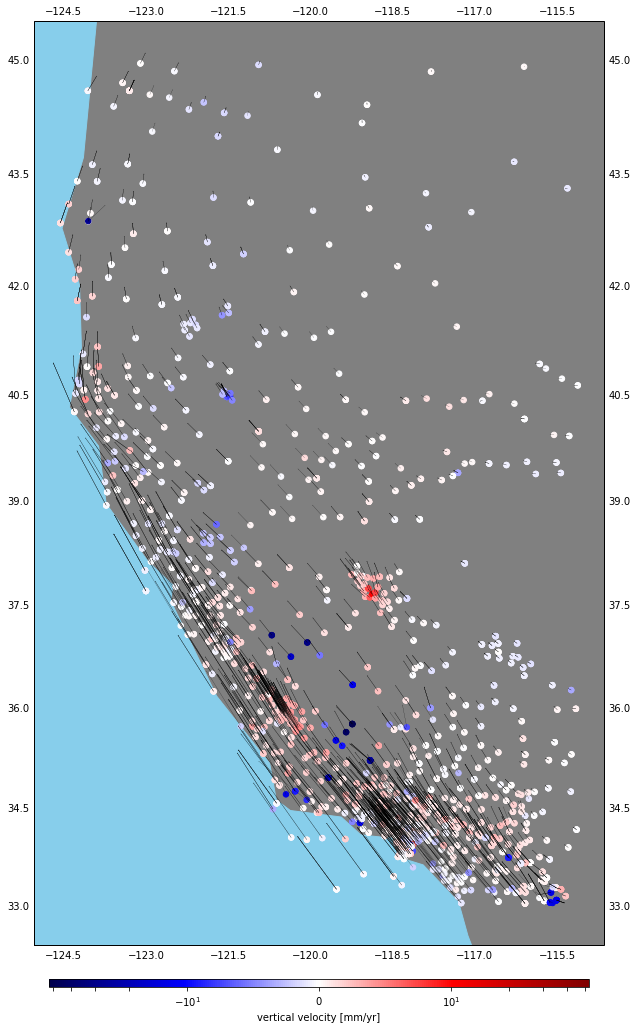

In [22]:
crs = ccrs.Mercator(
    central_longitude=np.mean(coordinates[0])
)
transform = ccrs.PlateCarree()

plt.figure(figsize=(11, 16))
ax = plt.subplot(111, projection=crs)

ax.add_feature(cfeature.LAND, facecolor="gray")
ax.add_feature(cfeature.OCEAN, facecolor="skyblue")
#ax.add_feature(cfeature.BORDERS, linewidth=0.1)
#ax.set_extent(region, crs=crs)

maxabs = vd.maxabs(components[-1])
cmap = plt.cm.seismic
norm = SymLogNorm(linthresh=10, linscale=1, vmin=-maxabs, vmax=maxabs)
cbargs = dict(orientation="horizontal", aspect=70, shrink=0.7, pad=0.03,
              label="vertical velocity [mm/yr]")

tmp = ax.scatter(*coordinates, c=components[-1], s=30, alpha=1, cmap=cmap, norm=norm,
                 vmin=-maxabs, vmax=maxabs, transform=transform)
plt.colorbar(tmp, ax=ax, **cbargs)
ax.quiver(*coordinates, *components[:2], scale=400, width=0.0003, 
          transform=transform)
ax.gridlines(draw_labels=True, linewidth=0)
plt.tight_layout()

In [23]:
projection = pyproj.Proj(proj="aea", lon_0=np.mean(coordinates[0]))
proj_coords = projection(*coordinates)

In [24]:
np.linalg.norm(components[-1])/np.linalg.norm(components[0])

0.21952645317513553

In [25]:
weights = tuple(w*vd.variance_to_weights(u**2) for u, w in zip(uncertainty, [0.1, 0.1, 1]))

In [26]:
def cat_forces(forces):
    return tuple(np.concatenate([f[i].ravel() for f in forces]) for i in range(2))

In [32]:
blockmean = vd.BlockReduce(reduction=np.mean, spacing=spacing*111e3, center_coordinates=False)
fault = vd.profile_coordinates((-120, 35.5), (-121.8, 37.5), size=100)[0]
fault_grid = vd.grid_coordinates([-122.5, -119.5, 35, 38], shape=(45, 45))
fault_mask = vd.distance_mask(fault, maxdist=0.15, coordinates=fault_grid)
fault_grid = projection(*[coord[fault_mask] for coord in fault_grid])
force_coords = blockmean.filter(
    cat_forces([proj_coords, fault_grid]), np.ones(data.shape[0] + fault_grid[0].size)
)[0]
force_coords = blockmean.filter(proj_coords, np.ones(data.shape[0]))[0]
print(force_coords[0].size)

792


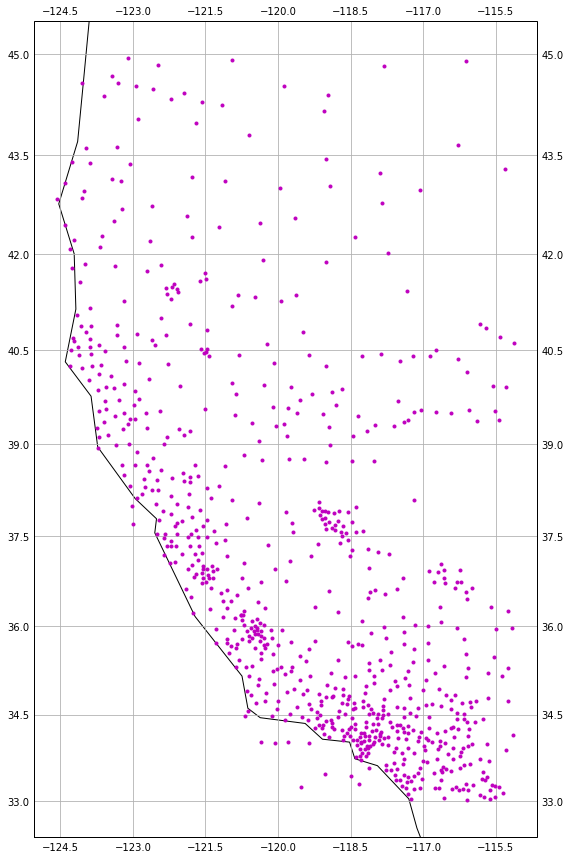

In [33]:
plt.figure(figsize=(11, 15))
ax = plt.subplot(111, projection=ccrs.Mercator())
plt.plot(*projection(*force_coords, inverse=True), "m.", transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

In [12]:
client = Client(LocalCluster(n_workers=2, threads_per_worker=2))
client

/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:40815 Dashboard: http://127.0.0.1:36919/status,Cluster Workers: 2 Cores: 4 Memory: 8.37 GB


In [34]:
%%time
spline = VectorSpline3DCV(
    #poissons=(-1, -0.5, 0, 0.5), 
    #depths=(1e3, 5e3, 10e3, 15e3, 20e3, 30e3, 40e3, 50e3),
    #dampings=(1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10),
    #couplings=(-1, -0.5, 0, 0.5, 1),
    poissons=(-1,), 
    depths=(1e3,),
    dampings=(1e-1,), 
    couplings=(-1,),
    force_coords=force_coords,
    client=client,
)
spline.fit(proj_coords, components, weights=weights)
print("Best spline configuration:\n", spline.gridder_)
print("Best score:", spline.scores_.max())
print("Score on training set:", spline.score(proj_coords, components, weights))

Best spline configuration:
 VectorSpline3D(coupling=-1, damping=0.1, depth=1000.0, depth_scale='nearest',
        force_coords=(array([ 204048.37868,  267090.3996 , ..., -118107.07379,  263731.84378]), array([3468806.54193, 3473023.75913, ..., 4797132.69082, 4798140.05523])),
        poisson=-1)
Best score: 0.9416156501349817
Score on training set: 0.9813400066704335
CPU times: user 3.84 s, sys: 1.36 s, total: 5.2 s
Wall time: 13.1 s


In [35]:
grid = spline.grid(
    region=region, spacing=spacing, projection=projection,
    dims=["latitude", "longitude"],
    data_names=["east_velocity", "north_velocity", "up_velocity"]
)
grid = vd.distance_mask(coordinates, maxdist=50e3, grid=grid, projection=projection)

/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/matplotlib/colors.py:1133: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


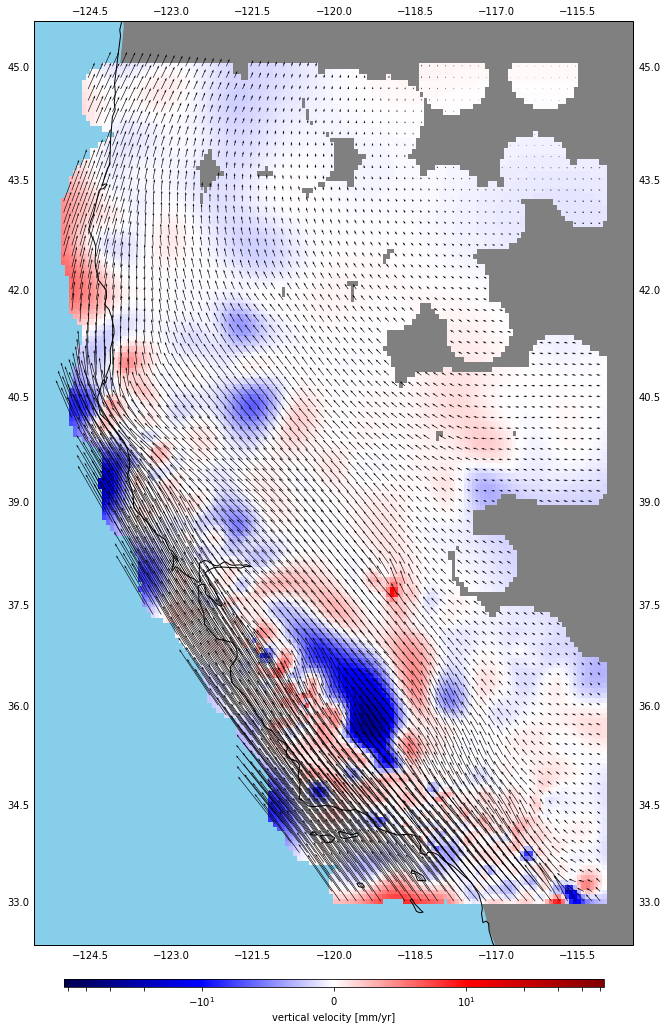

In [36]:
plt.figure(figsize=(11, 16))
ax = plt.subplot(111, projection=crs)

ax.add_feature(cfeature.LAND, facecolor="gray")
ax.add_feature(cfeature.OCEAN, facecolor="skyblue")

grid.up_velocity.plot.pcolormesh(
    ax=ax, cmap=cmap, vmin=-maxabs, vmax=maxabs, norm=norm, transform=transform,
    cbar_kwargs=cbargs
)
indexer = slice(None, None, 2)
# Downsample the arrows so we can actually see something
down = grid.isel(longitude=indexer, latitude=indexer)
ax.quiver(down.longitude.values, down.latitude.values, 
          down.east_velocity.values, down.north_velocity.values, 
          scale=400, width=0.001, transform=transform)

#ax.plot(*coordinates, 'm.', markersize=3, transform=transform)
#ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.coastlines(linewidth=1, resolution="50m")
ax.gridlines(draw_labels=True, linewidth=0)

plt.tight_layout()

In [67]:
predicted = spline.predict(proj_coords)
residuals = tuple(i - j for i, j in zip(components, predicted))

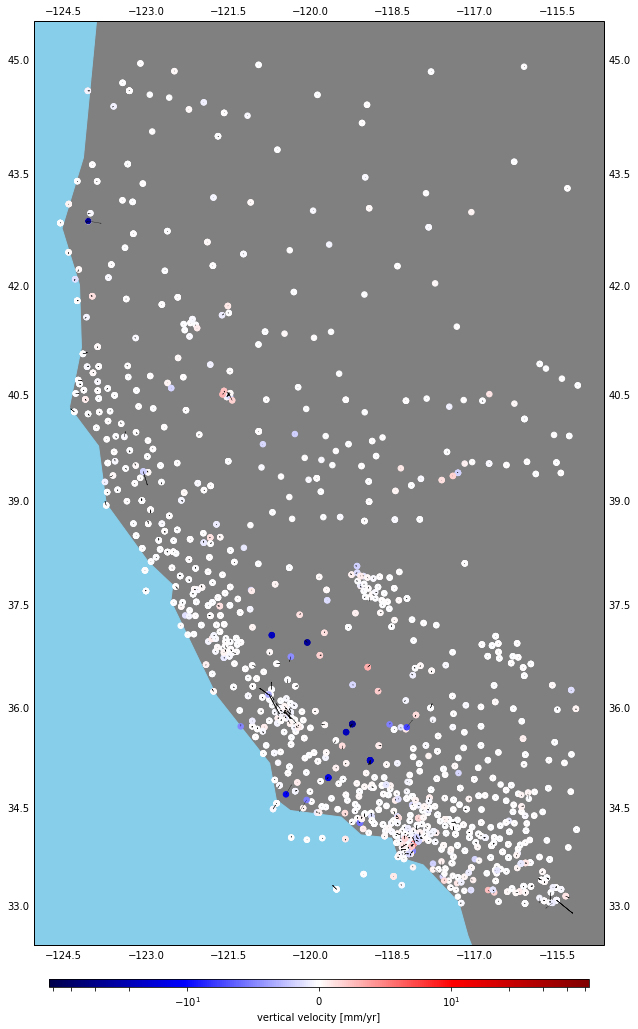

In [68]:
plt.figure(figsize=(11, 16))
ax = plt.subplot(111, projection=crs)

ax.add_feature(cfeature.LAND, facecolor="gray")
ax.add_feature(cfeature.OCEAN, facecolor="skyblue")

cmap = plt.cm.seismic
cbargs = dict(orientation="horizontal", aspect=70, shrink=0.7, pad=0.03,
              label="vertical velocity [mm/yr]")

tmp = ax.scatter(*coordinates, c=residuals[-1], s=30, alpha=1, cmap=cmap,
                 vmin=-maxabs, vmax=maxabs, norm=norm, transform=transform)
plt.colorbar(tmp, ax=ax, **cbargs)
ax.quiver(*coordinates, *residuals[:2], scale=400, width=0.0005, 
          transform=transform)
ax.gridlines(draw_labels=True, linewidth=0)
plt.tight_layout()

In [37]:
%%time
dampings = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
mindists = [10e3, 20e3, 30e3, 40e3, 50e3, 60e3, 70e3, 80e3, 90e3, 100e3]

parameter_combinations = [
    dict(zip(["damping", "mindist"], combo))
    for combo in itertools.product(dampings, mindists)
]

scores = []
for parameters in parameter_combinations:
    candidate = vd.Vector([
        vd.Spline(force_coords=force_coords, **parameters)
        for i in range(3)
    ])
    scores.append(client.submit(
        vd.cross_val_score,
        candidate,
        proj_coords,
        components,
        weights=weights,
    ))
scores = [np.mean(i.result()) for i in scores]
best = np.argmax(scores)
best_parameters = parameter_combinations[best]
spline_single = vd.Vector([
    vd.Spline(force_coords=force_coords, **best_parameters)
    for i in range(3)
]).fit(proj_coords, components, weights=weights)
print("Best parameters:", best_parameters)
print("Best score:", scores[best])
print("Score on training set:", spline_single.score(proj_coords, components, weights=weights))

Best parameters: {'damping': 1e-07, 'mindist': 60000.0}
Best score: 0.9439706280179131
Score on training set: 0.9848403092847633
CPU times: user 10.9 s, sys: 1.68 s, total: 12.6 s
Wall time: 1min 49s


In [38]:
grid_single = spline_single.grid(
    region=region, spacing=spacing, projection=projection,
    dims=["latitude", "longitude"],
    data_names=["east_velocity", "north_velocity", "up_velocity"]
)
grid_single = vd.distance_mask(coordinates, maxdist=50e3, grid=grid_single, projection=projection)

/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/matplotlib/colors.py:1133: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


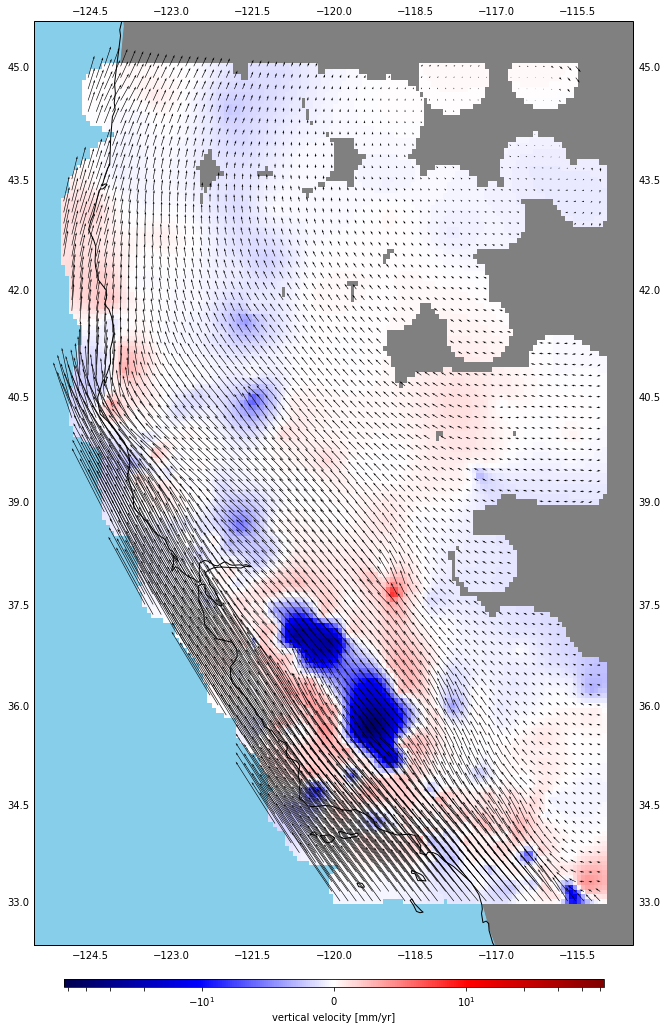

In [39]:
plt.figure(figsize=(11, 16))
ax = plt.subplot(111, projection=crs)

ax.add_feature(cfeature.LAND, facecolor="gray")
ax.add_feature(cfeature.OCEAN, facecolor="skyblue")

grid_single.up_velocity.plot.pcolormesh(
    ax=ax, cmap=cmap, vmin=-maxabs, vmax=maxabs, norm=norm, transform=transform,
    cbar_kwargs=cbargs
)
indexer = slice(None, None, 2)
# Downsample the arrows so we can actually see something
down = grid_single.isel(longitude=indexer, latitude=indexer)
ax.quiver(down.longitude.values, down.latitude.values, 
          down.east_velocity.values, down.north_velocity.values, 
          scale=400, width=0.001, transform=transform)

#ax.plot(*coordinates, 'm.', markersize=3, transform=transform)
#ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.coastlines(linewidth=1, resolution="50m")
ax.gridlines(draw_labels=True, linewidth=0)

plt.tight_layout()